# Edge swapping operation applied to explore network robustness

Here I will run the code to compare the different social networks datasets and sample them using an edge swapping process. 

Then, I will run a random deletion process of nodes and links.

In [74]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
%matplotlib inline

The following function aims to read a json network file. I took it from Stack Overflow.

In [23]:
data = None
with open('./Datasets/starwars-full-interactions.json') as file:
    data = json.load(file)

G_star = nx.empty_graph()

# Set node id to be index number
for i in range(0, len(data['nodes'])):
    G_star.add_node(i, attr_dict=data['nodes'][i])

# Add edges between nodes
for entry in data['links']:
    G_star.add_edge(entry['source'], entry['target'])

In [24]:

G_cel = nx.read_adjlist("./Datasets/celegans_edgelist.txt",nodetype=int) # C elegans
G_blg = nx.read_adjlist("./Datasets/out.moreno_blogs_blogs",nodetype=int, create_using=nx.DiGraph()) # Political Blogs
G_dol = nx.read_edgelist("./Datasets/soc-dolphins.txt")

# Starwars is not a connected network
largest_cc_star = max(nx.connected_components(G_star))
G_star = G_star.subgraph(largest_cc_star)

nameNetworks=["C-elegans","Blogs links","School Dolphins","Starwars"]
list_Networks=[G_cel,G_blg,G_dol,G_star,G_eco]

In [25]:
for graph in list_Networks:
    degree_list = [graph.degree()[node] for node in list(graph.nodes())]
    degree_list.sort()
    degrees=np.array(degree_list)
    print(np.average(degrees)," ",np.std(degrees))



10.66225165562914   24.25641739366145
31.086601307189543   45.32591508888669
5.129032258064516   2.931936885777937
7.302752293577981   7.7335259498847355
5.129032258064516   2.931936885777937


# MCMC definition and configuration

The following piece of code aims to create a MCMC transformation to randomize the networks. Each network is going to be sampled uding this method. What I am looking for is to keep preserve the node degree and the average degree, and by doing that, explore how the sampled network behaves w.r.t. $\langle d_{i} \rangle$, $C_{net}$, and $\langle d_{diam} \rangle$.

In [7]:
def T(g):
    
    while True:      
        N=g.number_of_edges()
        G=g.copy()
        
        ei = list(G.edges())[np.random.randint(0,N)]
        ej = list(G.edges())[np.random.randint(0,N)]

        if ei == ej or ei[0] == ej[0] or ei[0] == ej[1] or ei[1] == ej[0] or ei[1] == ej[1]:    
            continue
        
        node1 = np.random.randint(0,2)
        node2 = np.random.randint(0,2)     
               
        if node1 == node2:
            G.add_edge(ei[1],ej[1])
            G.add_edge(ei[0],ej[0])
            #print(G.number_of_edges())
            G.remove_edge(ei[0],ei[1])
            G.remove_edge(ej[0],ej[1])
            #print(G.number_of_edges())
            
        elif node1 != node2: 
            G.add_edge(ei[1],ej[0])
            G.add_edge(ei[0],ej[1])
            #print(G.number_of_edges())
            G.remove_edge(ei[0],ei[1])
            G.remove_edge(ej[0],ej[1])
            #print(G.number_of_edges())
 
        M = G.number_of_edges()
        
        if M<N or not nx.is_connected(G):       
            continue
        
        else:
            break
       
    return(G)


def T_diG(g):
    # This function is defined to sample a directed graph. It is different to work with a di-graph rather than to 
    # work with an undirected graph
    while True:      
        N=g.number_of_edges()
        G=g.copy()
        
        ei = list(G.edges())[np.random.randint(0,N)]
        ej = list(G.edges())[np.random.randint(0,N)]

        if ei == ej or ei[0] == ej[0] or ei[0] == ej[1] or ei[1] == ej[0] or ei[1] == ej[1]:    
            continue
        
        node1 = np.random.randint(0,2)
        node2 = np.random.randint(0,2)     
               
        if node1 == node2:
            G.add_edge(ei[1],ej[1])
            G.add_edge(ei[0],ej[0])
            #print(G.number_of_edges())
            G.remove_edge(ei[0],ei[1])
            G.remove_edge(ej[0],ej[1])
            #print(G.number_of_edges())
            
        elif node1 != node2: 
            G.add_edge(ei[1],ej[0])
            G.add_edge(ei[0],ej[1])
            #print(G.number_of_edges())
            G.remove_edge(ei[0],ei[1])
            G.remove_edge(ej[0],ej[1])
            #print(G.number_of_edges())
 
        M = G.number_of_edges()
        
        if M<N or not nx.is_strongly_connected(G):       
            continue
        
        else:
            break
       
    return(G)

In [8]:
def measuresD(g):
    dictD=dict(g.degree())
    listD=[dictD[k] for k in dictD.keys()]
    return(np.average(listD),np.std(listD))

# Random link deletion process and seeing how it works

In [27]:
# 
def random_deletion_links(G,array_to_delete):

    edges = list(G.edges()) 
    graph_modified = G.copy()
    
    if array_to_delete[0].size == 0:
        # There's no more links to delete.
        return graph_modified

    for index in np.nditer(array_to_delete):
        edge = edges[index]
        graph_modified.remove_edge(*edge)
    return graph_modified

# 
def random_deletion_nodes(G,array_to_delete):

    nodes = list(G.nodes()) 
    graph_modified = G.copy()
    
    if array_to_delete[0].size == 0:
        # There's no more links to delete.
        return graph_modified

    for index in np.nditer(array_to_delete):
        node = nodes[index]
        graph_modified.remove_node(node)
    return graph_modified

# 
def fraction_nodes_conncomp(G):
    total_nodes = G.number_of_nodes()
    
    # Retrieve largest connected component
    conn_graph = max(nx.connected_components(G),key=len)
    connected = G.subgraph(conn_graph)
    connected_size = connected.number_of_nodes()
    
    return connected_size/total_nodes

def fraction_nodes_stric_conncomp(G):
    total_nodes = G.number_of_nodes()
    
    # Retrieve largest connected component
    conn_graph = max(nx.strongly_connected_components(G),key=len)
    connected = G.subgraph(conn_graph)
    connected_size = connected.number_of_nodes()
    
    return connected_size/total_nodes

# Starwars network analysis

The following code aims to run the transformation on the network.

In [9]:
g_star=G_star.copy()

print(G_star.degree(4),G_star.edges(4)) # Sanity check
outs=[]
outs_shp=[]
outs_diam=[]
tmax=50
lagmax=100
print("t L <z> sigma_z C_net ddiam <<d>>")
for lag in range(lagmax):
    out=[tmax*lag,nx.number_of_edges(g_star),measuresD(g_star),nx.nx.transitivity(g_star),nx.diameter(g_star),nx.average_shortest_path_length(g_star)]
    outs.append(out[3])
    outs_shp.append(out[5])
    outs_diam.append(out[4])
    print(out)
    for t in range(tmax):
        g_star=T(g_star)

print(g_star.degree(4),g_star.edges(4)) #Sanity check

35 [(4, 3), (4, 0), (4, 11), (4, 13), (4, 9), (4, 15), (4, 10), (4, 17), (4, 20), (4, 31), (4, 29), (4, 30), (4, 14), (4, 37), (4, 2), (4, 43), (4, 44), (4, 45), (4, 46), (4, 33), (4, 8), (4, 38), (4, 51), (4, 52), (4, 1), (4, 50), (4, 54), (4, 55), (4, 21), (4, 60), (4, 61), (4, 64), (4, 67), (4, 70), (4, 63)]
t L <z> sigma_z C_net ddiam <<d>>
[0, 398, (7.302752293577981, 7.733525949884737), 0.34899445214979197, 6, 2.72782874617737]
[50, 398, (7.302752293577981, 7.733525949884737), 0.2460124826629681, 6, 2.511892626571526]
[100, 398, (7.302752293577981, 7.733525949884737), 0.20544382801664354, 5, 2.467720013591573]
[150, 398, (7.302752293577981, 7.733525949884737), 0.19764216366158113, 5, 2.467380224260958]
[200, 398, (7.302752293577981, 7.733525949884737), 0.19244105409153953, 5, 2.4597349643221205]
[250, 398, (7.302752293577981, 7.733525949884737), 0.1888002773925104, 5, 2.4541284403669725]
[300, 398, (7.302752293577981, 7.733525949884737), 0.19452149791955617, 5, 2.4930343187223922

[4150, 398, (7.302752293577981, 7.733525949884737), 0.2085644937586685, 4, 2.4515800203873597]
[4200, 398, (7.302752293577981, 7.733525949884737), 0.19712205270457697, 5, 2.4427454977913694]
[4250, 398, (7.302752293577981, 7.733525949884737), 0.18463938973647712, 5, 2.4294937138973838]
[4300, 398, (7.302752293577981, 7.733525949884737), 0.18567961165048544, 5, 2.443594971117907]
[4350, 398, (7.302752293577981, 7.733525949884737), 0.20180305131761442, 5, 2.4483520217465173]
[4400, 398, (7.302752293577981, 7.733525949884737), 0.1966019417475728, 6, 2.4644920149507303]
[4450, 398, (7.302752293577981, 7.733525949884737), 0.18307905686546463, 4, 2.4157322460074755]
[4500, 398, (7.302752293577981, 7.733525949884737), 0.1835991678224688, 5, 2.4471627590893648]
[4550, 398, (7.302752293577981, 7.733525949884737), 0.17215672676837726, 5, 2.441046551138294]
[4600, 398, (7.302752293577981, 7.733525949884737), 0.1742371705963939, 5, 2.4398572884811416]
[4650, 398, (7.302752293577981, 7.733525949884

In [28]:
#This code aims to get the average and standard deviation of the clustering coefficient

cnet = outs
avg_cnet = np.average(cnet)
std_cnet = np.std(cnet)
print("The average Cnet is {:.03f} and its standard deviation is {:.03f}"\
      .format(avg_cnet,std_cnet))


The average Cnet is 0.197 and its standard deviation is 0.019


In [11]:
#This code aims to get the distances measures over the iterations of the MCMC

diam = outs_diam
avg_diam = np.average(diam)
std_diam = np.std(diam)
print("The average diameter over realizations is {:.03f} +/- {:.03f} standard deviations.".format(avg_diam, std_diam))
print("")
shortest_pth = outs_shp
avg_shp = np.average(shortest_pth)
std_shp = np.std(shortest_pth)
print("The average shortest path over realizations is {:.03f} +/- {:.03f} standard deviations.".\
      format(avg_shp, std_shp))


The average diameter over realizations is 5.060 +/- 0.465 standard deviations.

The average shortest path over realizations is 2.470 +/- 0.035 standard deviations.


Text(0.5, 0, 't')

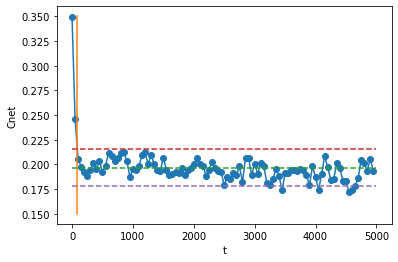

In [12]:
plt.plot(tmax*np.arange(lagmax),outs, "-o")
plt.plot([151/2,151/2],[0.15,0.35])
plt.plot([0,tmax*lagmax],[avg_cnet,avg_cnet], "--")
plt.plot([0,tmax*lagmax],[avg_cnet+std_cnet,avg_cnet+std_cnet], "--")
plt.plot([0,tmax*lagmax],[avg_cnet-std_cnet,avg_cnet-std_cnet], "--")
plt.ylabel("Cnet")
plt.xlabel("t")

Text(0.5, 0, 't')

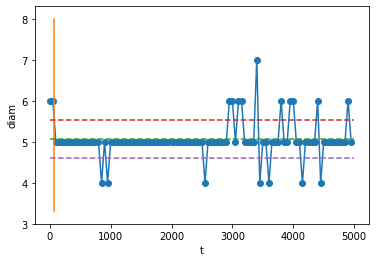

In [13]:
plt.plot(tmax*np.arange(lagmax),outs_diam, "-o")
plt.plot([151/2,151/2],[3.3,8])
plt.plot([0,tmax*lagmax],[avg_diam,avg_diam], "--")
plt.plot([0,tmax*lagmax],[avg_diam+std_diam,avg_diam+std_diam], "--")
plt.plot([0,tmax*lagmax],[avg_diam-std_diam,avg_diam-std_diam], "--")
plt.ylim(3, 8.3)
plt.ylabel("diam")
plt.xlabel("t")

Text(0.5, 0, 't')

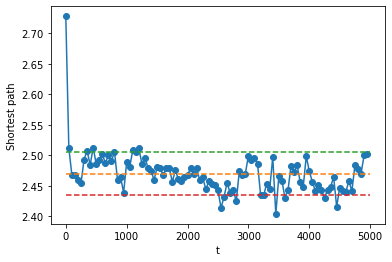

In [14]:
plt.plot(tmax*np.arange(lagmax),outs_shp, "-o")
#plt.plot([151/2,151/2],[3.3,8])
plt.plot([0,tmax*lagmax],[avg_shp,avg_shp], "--")
plt.plot([0,tmax*lagmax],[avg_shp+std_shp,avg_shp+std_shp], "--")
plt.plot([0,tmax*lagmax],[avg_shp-std_shp,avg_shp-std_shp], "--")
#plt.ylim(3, 8.3)
plt.ylabel("Shortest path")
plt.xlabel("t")

# Starwars analysis

# Link deletion

Computing each connected component size

In [16]:
probs_q = np.linspace(0.05,0.99,10) 

fraction_acum_actual = []
fraction_acum_rndm = []

g_starDeletion = G_star.copy()
g_deletion = g_star.copy()

L_star = G_star.number_of_edges()

for i in range(1200):
    
    fraction_actual = []
    fraction_randomized = []
    
    for q in probs_q:

        link_prob_star_actual = np.random.rand(L_star)
        link_prob_star_rndm = np.random.rand(L_star)


        edges_for_deletion_star_actual = np.where(link_prob_star_actual < q)
        edges_for_deletion_star_rndm = np.where(link_prob_star_rndm < q)


        G_modified_actual = random_deletion_links(g_starDeletion, edges_for_deletion_star_actual)
        G_modified_rdnm = random_deletion_links(g_deletion, edges_for_deletion_star_rndm)


        fraction_connected_actual = fraction_nodes_conncomp(G_modified_actual)
        fraction_connected_rndm = fraction_nodes_conncomp(G_modified_rdnm)


        fraction_actual.append(fraction_connected_actual)
        fraction_randomized.append(fraction_connected_rndm)
    
    fraction_acum_actual.append(fraction_actual)
    fraction_acum_rndm.append(fraction_randomized)

In [17]:
for i in range(len(fraction_acum_actual)):
    fraction_actual = [np.average(fraction_acum_actual[i][j]) for j in range(len(fraction_acum_actual[i]))]

for i in range(len(fraction_acum_rndm)):
    fraction_rndm = [np.average(fraction_acum_rndm[i][j]) for j in range(len(fraction_acum_rndm[i]))] 

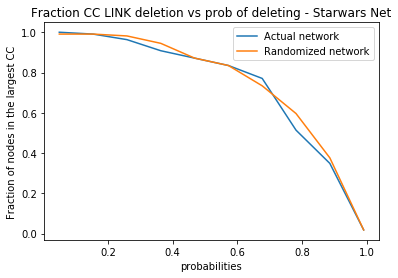

In [18]:
plt.plot(probs_q, fraction_actual,label="Actual network")
plt.plot(probs_q, fraction_rndm,label="Randomized network")
plt.xlabel("probabilities")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title(r"Fraction CC LINK deletion vs prob of deleting - Starwars Net")
plt.legend()

# Node deletion

In [19]:
N_star = G_star.number_of_nodes()

probs_q = np.linspace(0.05,0.9,19)

fraction_acum_actual = []
fraction_acum_rndm = []

for i in range(2000):

    g_starDeletion = G_star.copy()
    g_deletion = g_star.copy()
    
    fraction_actual = []
    fraction_randomized = []
    
    for q in probs_q:

        node_prob_star_actual = np.random.rand(N_star)
        node_prob_star_rndm = np.random.rand(N_star)


        node_for_deletion_star_actual = np.where(node_prob_star_actual < q)
        node_for_deletion_star_rndm = np.where(node_prob_star_rndm < q)


        G_modified_actual = random_deletion_nodes(g_starDeletion, node_for_deletion_star_actual)
        G_modified_rdnm = random_deletion_nodes(g_deletion, node_for_deletion_star_rndm)


        fraction_connected_actual = fraction_nodes_conncomp(G_modified_actual)
        fraction_connected_rndm = fraction_nodes_conncomp(G_modified_rdnm)


        fraction_actual.append(fraction_connected_actual)
        fraction_randomized.append(fraction_connected_rndm)
    
    fraction_acum_actual.append(fraction_actual)
    fraction_acum_rndm.append(fraction_randomized)

In [20]:
for i in range(len(fraction_acum_actual)):
    fraction_actual = [np.average(fraction_acum_actual[i][j]) for j in range(len(fraction_acum_actual[i]))]

for i in range(len(fraction_acum_rndm)):
    fraction_rndm = [np.average(fraction_acum_rndm[i][j]) for j in range(len(fraction_acum_rndm[i]))]
    

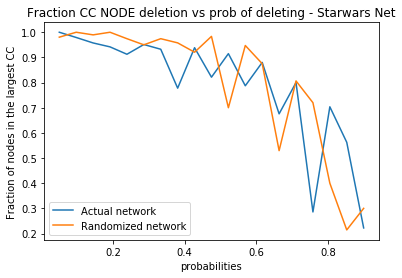

In [21]:
plt.plot(probs_q, fraction_actual,label="Actual network")
plt.plot(probs_q, fraction_rndm,label="Randomized network")
plt.xlabel("probabilities")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC NODE deletion vs prob of deleting - Starwars Net")
plt.legend()

# Blog Network

In [79]:
print(G_blg.number_of_nodes())
blogs = nx.strongly_connected_components(G_blg)
blogs = list(blogs)

blogs.sort(reverse=True)

largest = max(nx.strongly_connected_components(G_blg), key=len)
newGraph = G_blg.subgraph(largest)

nx.is_strongly_connected(newGraph)

1224


True

In [345]:
g_blg=newGraph.copy()

print(newGraph.degree(4),newGraph.edges(4)) # Sanity check
outs=[]
outs_shp=[]
outs_diam=[]
tmax=70
lagmax=100
print("t L <z> sigma_z C_net ddiam <<d>>")
for lag in range(lagmax):
    out=[tmax*lag,nx.number_of_edges(g_blg),measuresD(g_blg),nx.nx.transitivity(g_blg),nx.diameter(g_blg),nx.average_shortest_path_length(g_blg)]
    outs.append(out[3])
    outs_shp.append(out[5])
    outs_diam.append(out[4])
    print(out)
    for t in range(tmax):
        g_blg=T_diG(g_blg)

print(g_blg.degree(4),g_blg.edges(4)) #Sanity check




57 [(4, 3), (4, 235), (4, 260), (4, 5), (4, 26), (4, 240), (4, 91), (4, 6), (4, 82), (4, 83), (4, 40), (4, 11)]
t L <z> sigma_z C_net ddiam <<d>>
[0, 15783, (39.80580075662043, 45.85962040293493), 0.22262231812968886, 8, 3.1887283936464264]
[70, 15783, (39.80580075662043, 45.85962040293493), 0.2190966639143598, 8, 3.109431324595259]
[140, 15783, (39.80580075662043, 45.85962040293493), 0.21648683128409146, 8, 3.0546543620314113]
[210, 15783, (39.80580075662043, 45.85962040293493), 0.21389489386249613, 8, 3.008209459029131]
[280, 15783, (39.80580075662043, 45.85962040293493), 0.21099724083563265, 8, 2.9790480466709974]
[350, 15783, (39.80580075662043, 45.85962040293493), 0.20871061077255693, 8, 2.9519644745054583]
[420, 15783, (39.80580075662043, 45.85962040293493), 0.20633691705817833, 8, 2.9322082744213893]
[490, 15783, (39.80580075662043, 45.85962040293493), 0.20368400111993634, 8, 2.9029401836778885]
[560, 15783, (39.80580075662043, 45.85962040293493), 0.20126764179086862, 8, 2.89077

[5880, 15783, (39.80580075662043, 45.85962040293493), 0.12970842293030985, 7, 2.6365244500490403]
[5950, 15783, (39.80580075662043, 45.85962040293493), 0.12926490349376984, 7, 2.6357984001426624]
[6020, 15783, (39.80580075662043, 45.85962040293493), 0.12937522344004473, 7, 2.637145413784758]
[6090, 15783, (39.80580075662043, 45.85962040293493), 0.1293267117601094, 7, 2.637159743717121]
[6160, 15783, (39.80580075662043, 45.85962040293493), 0.12897211661103009, 7, 2.6369177270816615]
[6230, 15783, (39.80580075662043, 45.85962040293493), 0.1283959755462346, 7, 2.635166290903996]
[6300, 15783, (39.80580075662043, 45.85962040293493), 0.1280301462262428, 7, 2.633023169908416]
[6370, 15783, (39.80580075662043, 45.85962040293493), 0.12768157146549497, 7, 2.6314118486249636]
[6440, 15783, (39.80580075662043, 45.85962040293493), 0.127615145426858, 7, 2.631389557619066]
[6510, 15783, (39.80580075662043, 45.85962040293493), 0.12718451904172431, 7, 2.6310074260893934]
[6580, 15783, (39.805800756620

In [346]:
#This code aims to get the average and standar deviation of the clustering coefficient

cnet = outs
avg_cnet = np.average(cnet)
std_cnet = np.std(cnet)
print("The average Cnet is {:.03f} and its standard deviation is {:.03f}"\
      .format(avg_cnet,std_cnet))


The average Cnet is 0.154 and its standard deviation is 0.026


In [347]:
#This code aims to get the distances measures over the iterations of the MCMC

diam = outs_diam
avg_diam = np.average(diam)
std_diam = np.std(diam)
print("The average diameter over realizations is {:.03f} +/- {:.03f} standard deviations.".format(avg_diam, std_diam))
print("")
shortest_pth = outs_shp
avg_shp = np.average(shortest_pth)
std_shp = np.std(shortest_pth)
print("The average shortest path over realizations is {:.03f} +/- {:.03f} standard deviations.".\
      format(avg_shp, std_shp))


The average diameter over realizations is 7.230 +/- 0.421 standard deviations.

The average shortest path over realizations is 2.715 +/- 0.111 standard deviations.


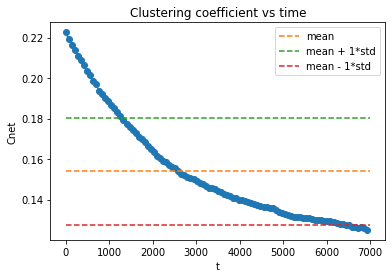

In [348]:
plt.plot(tmax*np.arange(lagmax),outs, "-o")
#plt.plot([151/2,151/2],[0.15,0.35])
plt.plot([0,tmax*lagmax],[avg_cnet,avg_cnet], "--", label="mean")
plt.plot([0,tmax*lagmax],[avg_cnet+std_cnet,avg_cnet+std_cnet], "--", label="mean + 1*std")
plt.plot([0,tmax*lagmax],[avg_cnet-std_cnet,avg_cnet-std_cnet], "--", label="mean - 1*std")
plt.ylabel("Cnet")
plt.xlabel("t")
plt.title("Clustering coefficient vs time")
plt.legend()

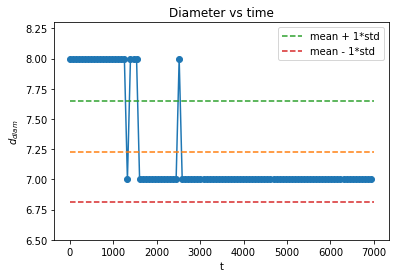

In [359]:
plt.plot(tmax*np.arange(lagmax),outs_diam, "-o")
#plt.plot([151/2,151/2],[3.3,8])
plt.plot([0,tmax*lagmax],[avg_diam,avg_diam], "--")
plt.plot([0,tmax*lagmax],[avg_diam+std_diam,avg_diam+std_diam], "--", label="mean + 1*std")
plt.plot([0,tmax*lagmax],[avg_diam-std_diam,avg_diam-std_diam], "--", label="mean - 1*std")
plt.ylim(6.5, 8.3)
plt.ylabel(r"$d_{diam}$")
plt.xlabel("t")
plt.title("Diameter vs time")
plt.legend()

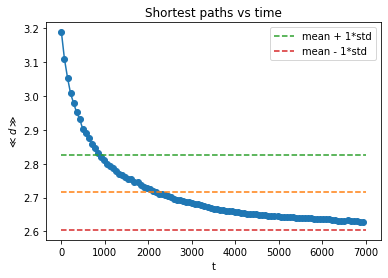

In [357]:
plt.plot(tmax*np.arange(lagmax),outs_shp, "-o")
#plt.plot([151/2,151/2],[3.3,8])
plt.plot([0,tmax*lagmax],[avg_shp,avg_shp], "--")
plt.plot([0,tmax*lagmax],[avg_shp+std_shp,avg_shp+std_shp], "--", label="mean + 1*std")
plt.plot([0,tmax*lagmax],[avg_shp-std_shp,avg_shp-std_shp], "--", label="mean - 1*std")
#plt.ylim(3, 8.3)
plt.ylabel(r"$\ll d \gg$")
plt.xlabel("t")
plt.title("Shortest paths vs time")
plt.legend()

# Node deletion

In [335]:
probs_q = np.linspace(0.00,0.95,20) 

fraction_blog_acum_actual = []
fraction_blog_acum_rndm = []

g_blogDeletion = newGraph.copy()
g_blgdeletion = g_blg.copy()

nodes_blog = newGraph.number_of_nodes()

for i in range(300):
    fraction_actual_blog = []
    fraction_randomized_blog = []
    
    for q in probs_q:

        node_prob_blog_actual = np.random.rand(nodes_blog)
        node_prob_blog_rndm = np.random.rand(nodes_blog)


        nodes_for_deletion_blog_actual = np.where(node_prob_blog_actual < q)
        nodes_for_deletion_blog_rndm = np.where(node_prob_blog_rndm < q)


        Gblog_modified_actual = random_deletion_nodes(g_blogDeletion, nodes_for_deletion_blog_actual)
        Gblog_modified_rdnm = random_deletion_nodes(g_blgdeletion, nodes_for_deletion_blog_rndm)


        fraction_connected_actual = fraction_nodes_stric_conncomp(Gblog_modified_actual)
        fraction_connected_rndm = fraction_nodes_stric_conncomp(Gblog_modified_rdnm)


        fraction_actual_blog.append(fraction_connected_actual)
        fraction_randomized_blog.append(fraction_connected_rndm)
    
    fraction_blog_acum_actual.append(fraction_actual_blog)
    fraction_blog_acum_rndm.append(fraction_randomized_blog)

In [336]:
for i in range(len(fraction_blog_acum_actual)):
    fraction_actual_blg = [np.average(fraction_blog_acum_actual[i][j]) for j in range(len(fraction_blog_acum_actual[i]))]

for i in range(len(fraction_blog_acum_rndm)):
    fraction_rndm_blg = [np.average(fraction_blog_acum_rndm[i][j]) for j in range(len(fraction_blog_acum_rndm[i]))]
    

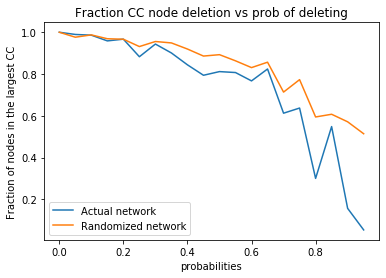

In [337]:
plt.plot(probs_q,fraction_actual_blg,label="Actual network")
plt.plot(probs_q,fraction_rndm_blg,label="Randomized network")
plt.xlabel("probabilities")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC node deletion vs prob of deleting")

plt.legend()

# Link deletion

In [338]:
probs_q = np.linspace(0.00,0.95,20) 

fraction_blog_acum_actual = []
fraction_blog_acum_rndm = []

g_blogDeletion = newGraph.copy()
g_blgdeletion = g_blg.copy()

links_blog = newGraph.number_of_edges()

for i in range(300):
    fraction_actual_blog = []
    fraction_randomized_blog = []
    
    for q in probs_q:

        link_prob_blog_actual = np.random.rand(links_blog)
        link_prob_blog_rndm = np.random.rand(links_blog)


        links_for_deletion_blog_actual = np.where(link_prob_blog_actual < q)
        links_for_deletion_blog_rndm = np.where(link_prob_blog_rndm < q)


        Gblog_modified_actual = random_deletion_links(g_blogDeletion, links_for_deletion_blog_actual)
        Gblog_modified_rdnm = random_deletion_links(g_blgdeletion, links_for_deletion_blog_rndm)


        fraction_connected_actual = fraction_nodes_stric_conncomp(Gblog_modified_actual)
        fraction_connected_rndm = fraction_nodes_stric_conncomp(Gblog_modified_rdnm)


        fraction_actual_blog.append(fraction_connected_actual)
        fraction_randomized_blog.append(fraction_connected_rndm)
    
    fraction_blog_acum_actual.append(fraction_actual_blog)
    fraction_blog_acum_rndm.append(fraction_randomized_blog)

In [339]:
for i in range(len(fraction_blog_acum_actual)):
    fraction_actual_blg = [np.average(fraction_blog_acum_actual[i][j]) for j in range(len(fraction_blog_acum_actual[i]))]

for i in range(len(fraction_blog_acum_rndm)):
    fraction_rndm_blg = [np.average(fraction_blog_acum_rndm[i][j]) for j in range(len(fraction_blog_acum_rndm[i]))]
    
    

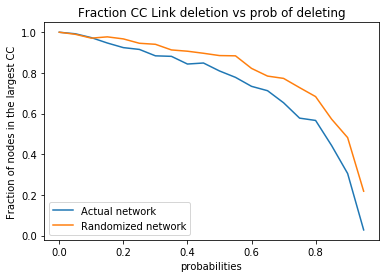

In [340]:
plt.plot(probs_q,fraction_actual_blg,label="Actual network")
plt.plot(probs_q,fraction_rndm_blg,label="Randomized network")
plt.xlabel("probabilities")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC Link deletion vs prob of deleting")
plt.legend()

# C-elegans Network

In [51]:
g_cel=G_cel.copy()

print(G_cel.degree(4),G_cel.edges(4)) # Sanity check
outs_cel=[]
outs_shp_cel=[]
outs_diam_cel=[]
tmax=50
lagmax=100
print("t L <z> sigma_z C_net ddiam <<d>>")
for lag in range(lagmax):
    out_cel=[tmax*lag,nx.number_of_edges(g_cel),measuresD(g_cel),nx.nx.transitivity(g_cel),nx.diameter(g_cel),nx.average_shortest_path_length(g_cel)]
    outs_cel.append(out_cel[3])
    outs_shp_cel.append(out_cel[5])
    outs_diam_cel.append(out_cel[4])
    print(out_cel)
    for t in range(tmax):
        g_cel=T(g_cel)

print(g_cel.degree(4),g_cel.edges(4)) #Sanity check

7 [(4, 147), (4, 1), (4, 404), (4, 145), (4, 243), (4, 6), (4, 241)]
t L <z> sigma_z C_net ddiam <<d>>
[0, 2415, (10.66225165562914, 24.25641739366145), 0.09633267633849237, 4, 2.1659438551251244]
[50, 2415, (10.66225165562914, 24.25641739366145), 0.09309208400646203, 4, 2.1612651155521694]
[100, 2415, (10.66225165562914, 24.25641739366145), 0.08990985751671998, 4, 2.1545156185899312]
[150, 2415, (10.66225165562914, 24.25641739366145), 0.08735097412038383, 4, 2.1477954247982964]
[200, 2415, (10.66225165562914, 24.25641739366145), 0.08605214694194048, 4, 2.1458711832620287]
[250, 2415, (10.66225165562914, 24.25641739366145), 0.08459823592129495, 4, 2.1459395573267694]
[300, 2415, (10.66225165562914, 24.25641739366145), 0.08281477173596975, 4, 2.139737052882455]
[350, 2415, (10.66225165562914, 24.25641739366145), 0.08106222136072883, 4, 2.1397956592236613]
[400, 2415, (10.66225165562914, 24.25641739366145), 0.08013180849001744, 4, 2.140235206782707]
[450, 2415, (10.66225165562914, 24.256

[4250, 2415, (10.66225165562914, 24.25641739366145), 0.07600866173607407, 4, 2.1240012502686123]
[4300, 2415, (10.66225165562914, 24.25641739366145), 0.07731948826360464, 4, 2.1294223368301783]
[4350, 2415, (10.66225165562914, 24.25641739366145), 0.07753153373129341, 4, 2.1288753443122546]
[4400, 2415, (10.66225165562914, 24.25641739366145), 0.07751225687059443, 4, 2.1264334134286664]
[4450, 2415, (10.66225165562914, 24.25641739366145), 0.07737731884570158, 4, 2.1280353200883004]
[4500, 2415, (10.66225165562914, 24.25641739366145), 0.07730021140290566, 4, 2.128582312606224]
[4550, 2415, (10.66225165562914, 24.25641739366145), 0.07456289718365065, 4, 2.1239719470980094]
[4600, 2415, (10.66225165562914, 24.25641739366145), 0.07462072776574759, 4, 2.123981714821544]
[4650, 2415, (10.66225165562914, 24.25641739366145), 0.07591227743257918, 4, 2.124343120592315]
[4700, 2415, (10.66225165562914, 24.25641739366145), 0.07512192614392105, 4, 2.1199378772783217]
[4750, 2415, (10.66225165562914, 

In [222]:
#This code aims to get the average and standar deviation of the clustering coefficient

cnet_cel = outs_cel
avg_cnet_cel = np.average(cnet_cel)
std_cnet_cel = np.std(cnet_cel)
print("The average Cnet is {:.03f} and its standard deviation is {:.03f}"\
      .format(avg_cnet_cel,std_cnet_cel))


The average Cnet is 0.076 and its standard deviation is 0.004


In [223]:
#This code aims to get the distances measures over the iterations of the MCMC

diam_cel = outs_diam_cel
avg_diam_cel = np.average(diam_cel)
std_diam_cel = np.std(diam_cel)
print("The average diameter over realizations is {:.03f} +/- {:.03f} standard deviations.".\
      format(avg_diam_cel, std_diam_cel))
print("")
shortest_pth_cel = outs_shp_cel
avg_shp_cel = np.average(shortest_pth_cel)
std_shp_cel = np.std(shortest_pth_cel)
print("The average shortest path over realizations is {:.03f} +/- {:.03f} standard deviations.".\
      format(avg_shp_cel, std_shp_cel))


The average diameter over realizations is 4.350 +/- 0.477 standard deviations.

The average shortest path over realizations is 2.143 +/- 0.007 standard deviations.


In [224]:
#This code aims to get the distances measures over the iterations of the MCMC

diam_cel = outs_diam_cel
avg_diam_cel = np.average(diam_cel)
std_diam_cel = np.std(diam_cel)
print("The average diameter over realizations is {:.03f} +/- {:.03f} standard deviations.".format(avg_diam, std_diam))
print("")
shortest_pth_cel = outs_shp_cel
avg_shp_cel = np.average(shortest_pth_cel)
std_shp_cel = np.std(shortest_pth_cel)
print("The average shortest path over realizations is {:.03f} +/- {:.03f} standard deviations.".\
      format(avg_shp_cel, std_shp_cel))

The average diameter over realizations is 6.620 +/- 0.704 standard deviations.

The average shortest path over realizations is 2.143 +/- 0.007 standard deviations.


Text(0.5, 0, 't')

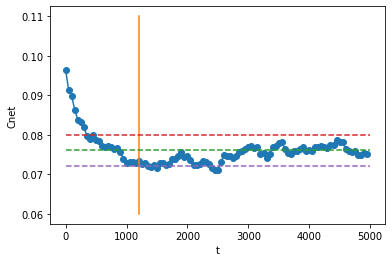

In [233]:
plt.plot(tmax*np.arange(lagmax),outs_cel, "-o")
plt.plot([g_cel.number_of_edges()/2,g_cel.number_of_edges()/2],[0.06,0.11])
plt.plot([0,tmax*lagmax],[avg_cnet_cel,avg_cnet_cel], "--")
plt.plot([0,tmax*lagmax],[avg_cnet_cel+std_cnet_cel,avg_cnet_cel+std_cnet_cel], "--")
plt.plot([0,tmax*lagmax],[avg_cnet_cel-std_cnet_cel,avg_cnet_cel-std_cnet_cel], "--")
plt.ylabel("Cnet")
plt.xlabel("t")

Text(0.5, 0, 't')

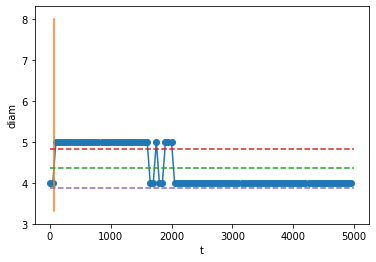

In [226]:
plt.plot(tmax*np.arange(lagmax),outs_diam_cel, "-o")
plt.plot([151/2,151/2],[3.3,8])
plt.plot([0,tmax*lagmax],[avg_diam_cel,avg_diam_cel], "--")
plt.plot([0,tmax*lagmax],[avg_diam_cel+std_diam_cel,avg_diam_cel+std_diam_cel], "--")
plt.plot([0,tmax*lagmax],[avg_diam_cel-std_diam_cel,avg_diam_cel-std_diam_cel], "--")
plt.ylim(3, 8.3)
plt.ylabel("diam")
plt.xlabel("t")

Text(0.5, 0, 't')

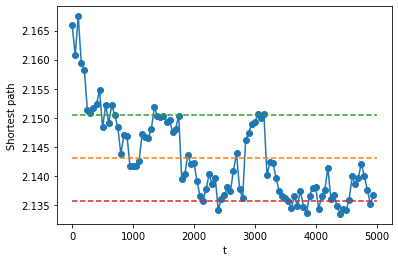

In [227]:
plt.plot(tmax*np.arange(lagmax),outs_shp_cel, "-o")
#plt.plot([151/2,151/2],[3.3,8])
plt.plot([0,tmax*lagmax],[avg_shp_cel,avg_shp_cel], "--")
plt.plot([0,tmax*lagmax],[avg_shp_cel+std_shp_cel,avg_shp_cel+std_shp_cel], "--")
plt.plot([0,tmax*lagmax],[avg_shp_cel-std_shp_cel,avg_shp_cel-std_shp_cel], "--")
#plt.ylim(3, 8.3)
plt.ylabel("Shortest path")
plt.xlabel("t")

# Node deletion

In [263]:
probs_q = np.linspace(0.00,0.95,20) 

fraction_cel_acum_actual = []
fraction_cel_acum_rndm = []

g_celDeletion_actual = G_cel.copy()
g_celDeletion_rdn = g_cel.copy()

nodes_cel = G_cel.number_of_nodes()

for i in range(3000):
    fraction_actual_cel = []
    fraction_randomized_cel = []
    
    for q in probs_q:

        node_prob_cel_actual = np.random.rand(nodes_cel)
        node_prob_cel_rndm = np.random.rand(nodes_cel)


        nodes_for_deletion_cel_actual = np.where(node_prob_cel_actual < q)
        nodes_for_deletion_cel_rndm = np.where(node_prob_cel_rndm < q)


        Gcel_modified_actual = random_deletion_nodes(g_celDeletion_actual, nodes_for_deletion_cel_actual)
        Gcel_modified_rdnm = random_deletion_nodes(g_celDeletion_rdn, nodes_for_deletion_cel_rndm)


        fraction_connected_actual_cel = fraction_nodes_conncomp(Gcel_modified_actual)
        fraction_connected_rndm_cel = fraction_nodes_conncomp(Gcel_modified_rdnm)


        fraction_actual_cel.append(fraction_connected_actual_cel)
        fraction_randomized_cel.append(fraction_connected_rndm_cel)
    
    fraction_cel_acum_actual.append(fraction_actual_cel)
    fraction_cel_acum_rndm.append(fraction_randomized_cel)

In [264]:
for i in range(len(fraction_cel_acum_actual)):
    fraction_actual_cel = [np.average(fraction_cel_acum_actual[i][j]) for j in range(len(fraction_cel_acum_actual[i]))]

for i in range(len(fraction_cel_acum_rndm)):
    fraction_rndm_cel = [np.average(fraction_cel_acum_rndm[i][j]) for j in range(len(fraction_cel_acum_rndm[i]))]
    


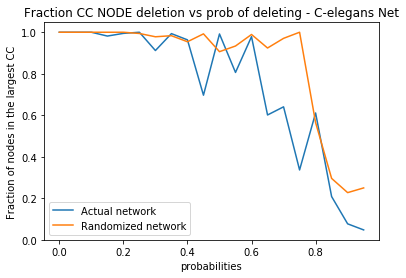

In [292]:
plt.plot(probs_q,fraction_actual_cel,label="Actual network")
plt.plot(probs_q,fraction_rndm_cel,label="Randomized network")
plt.xlabel("probabilities")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC NODE deletion vs prob of deleting - C-elegans Net")
plt.legend()

# Link deletion

In [260]:
probs_q = np.linspace(0.00,0.95,20) 

fraction_linkCel_acum_actual = []
fraction_linkCel_acum_rndm = []

g_celDeletion_actual = G_cel.copy()
g_celDeletion_rdn = g_cel.copy()

links_cel = G_cel.number_of_edges()

for i in range(2000):
    fraction_actual_linkCel = []
    fraction_randomized_linkCel = []
    
    for q in probs_q:

        link_prob_cel_actual = np.random.rand(links_cel)
        link_prob_cel_rndm = np.random.rand(links_cel)


        links_for_deletion_cel_actual = np.where(link_prob_cel_actual < q)
        links_for_deletion_cel_rndm = np.where(link_prob_cel_rndm < q)


        Gcel_link_modified_actual = random_deletion_links(g_celDeletion_actual, links_for_deletion_cel_actual)
        Gcel_link_modified_rdnm = random_deletion_links(g_celDeletion_rdn, links_for_deletion_cel_rndm)


        fraction_connected_actual_linkCel = fraction_nodes_conncomp(Gcel_link_modified_actual)
        fraction_connected_rndm_linkCel = fraction_nodes_conncomp(Gcel_link_modified_rdnm)


        fraction_actual_linkCel.append(fraction_connected_actual_linkCel)
        fraction_randomized_linkCel.append(fraction_connected_rndm_linkCel)
    
    fraction_linkCel_acum_actual.append(fraction_actual_linkCel)
    fraction_linkCel_acum_rndm.append(fraction_randomized_linkCel)

In [266]:
for i in range(len(fraction_linkCel_acum_actual)):
    fraction_actual_linkcel = [np.average(fraction_linkCel_acum_actual[i][j]) for j in range(len(fraction_linkCel_acum_actual[i]))]

for i in range(len(fraction_linkCel_acum_rndm)):
    fraction_rndm_linkcel = [np.average(fraction_linkCel_acum_rndm[i][j]) for j in range(len(fraction_linkCel_acum_rndm[i]))]


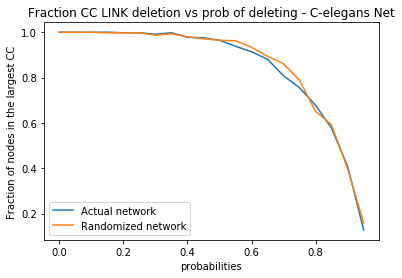

In [291]:
plt.plot(probs_q,fraction_actual_linkcel,label="Actual network")
plt.plot(probs_q,fraction_rndm_linkcel,label="Randomized network")
plt.xlabel("probabilities")
plt.ylabel("Fraction of nodes in the largest CC")
plt.title("Fraction CC LINK deletion vs prob of deleting - C-elegans Net")
plt.legend()

/Users/juliocorrearios/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/juliocorrearios/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


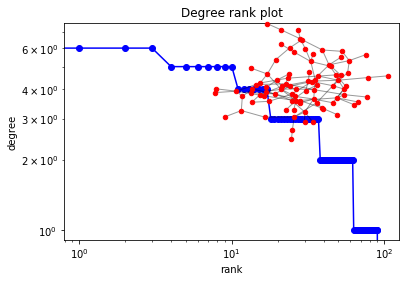

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.gnp_random_graph(100,0.02)

degree_sequence=sorted(dict(nx.degree(G)).values(),reverse=True) # degree sequence
#print "Degree sequence", degree_sequence
dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45,0.45,0.45,0.45])
Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)[0]
pos=nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc,pos,node_size=20)
nx.draw_networkx_edges(Gcc,pos,alpha=0.4)

plt.savefig("degree_histogram.png")
plt.show()